In [1]:
import os

In [2]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

In [3]:
from dotenv import load_dotenv

In [4]:
load_dotenv()

True

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

/home/joseph/Source/Sample/GenAI/LCEx/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.7,convert_system_message_to_human=True)

In [7]:
from langchain_core.tools import tool

In [ ]:
@tool
def search(query: str):
    """Call to surf the web."""
    if "blr" in query.lower() or "bangalore" in query.lower():
        return "It's 25 degrees and foggy."
    return "It's 35 degrees and sunny."


In [9]:
tools = [search]

In [10]:
tool_node = ToolNode(tools)

In [11]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


In [12]:
from typing import Literal

In [13]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

In [18]:
workflow=StateGraph(MessagesState)

In [19]:
workflow.add_node("agent",call_model)

In [20]:
workflow.add_node("tools",call_model)

In [21]:
# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

In [22]:
workflow.set_entry_point("agent")

In [23]:
# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

In [24]:
checkpointer = MemorySaver()

In [25]:
app=workflow.compile(checkpointer=checkpointer)

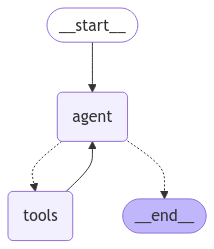

In [26]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
from langchain_core.messages import HumanMessage

In [35]:
# Use the Runnable
final_state = app.invoke({"messages": [HumanMessage(content="what is the tomorrow's weather in blr?")]},config={"configurable": {"thread_id": 42}})

/home/joseph/Source/Sample/GenAI/LCEx/venv/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:310: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


In [36]:
final_state["messages"][-1].content
final_state

{'messages': [HumanMessage(content="what is the tomorrow's weather in bangalore?", additional_kwargs={}, response_metadata={}, id='2cec5e73-7c92-4496-b288-de46f3c13481'),
  AIMessage(content="I do not have real-time capabilities and my knowledge cutoff is April 2023. Therefore, I cannot provide you with tomorrow's weather in Bangalore. \n\nTo get the most up-to-date and accurate weather forecast, I recommend checking a reputable weather app or website, such as the India Meteorological Department (IMD) website or app, AccuWeather, or The Weather Channel.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HA

In [33]:

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in app.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Goodbye!
